In [3]:
import json
import csv

import sys
sys.path.append("../../")
sys.path.append("/home/rosa/DefmodEnv/lib/python3.7/site-packages/")

import numpy as np
import matplotlib.pyplot as plt
import torch
import copy
import math
import pickle

import implicitmodules.torch as dm
from implicitmodules.torch.HamiltonianDynamic import Hamiltonian, shoot
from implicitmodules.torch.MultiShape import MultiShapeHamiltonian

torch.set_default_tensor_type(torch.FloatTensor)
dtype = torch.float32

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.


/home/rosa/DefmodEnv/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [4]:
source = np.load('../../data/organs_source.npy', allow_pickle=True).tolist()
target = np.load('../../data/organs_target.npy', allow_pickle=True).tolist()

In [6]:
source[0] = source[0].to(dtype)
source[1] = source[1].to(dtype)
target[0] = target[0].to(dtype)
target[1] = target[1].to(dtype)

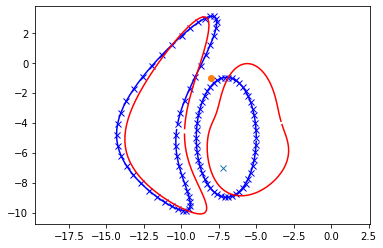

In [5]:
NN = 2
boundary0 = dm.MultiShape.Boundary(copy.copy(source[0][::NN]))
boundary1 = dm.MultiShape.Boundary(copy.copy(source[1][::NN]))



source_deformable0 = dm.Models.DeformablePoints(source[0])
source_deformable1 = dm.Models.DeformablePoints(source[1])
target_deformable0 = dm.Models.DeformablePoints(target[0])
target_deformable1 = dm.Models.DeformablePoints(target[1])



scale_scaling = 1.2
scaling = dm.DeformationModules.LocalScaling(2, scale_scaling, gd=torch.tensor([[-7.2, -7]], dtype=dtype, requires_grad=True))
scale_rotation = 15
rotation = dm.DeformationModules.LocalRotation(2, scale_rotation, gd=torch.tensor([[-8., -1.]], dtype=dtype, requires_grad=True))
scale_transl = 10
#translation = dm.DeformationModules.GlobalTranslation(2)
scale_translation = 10.
translation = dm.DeformationModules.Translations(2, 1, scale_translation, gd=torch.tensor([[-7., -4.]]))
translation.to_(dtype)
attach = dm.Attachment.EuclideanPointwiseDistanceAttachment()

shoot_solver = 'torch_euler'
shoot_it = 10

plt.plot(source[0][:,0].detach(), source[0][:,1].detach(), '-b')
plt.plot(source[1][:,0].detach(), source[1][:,1].detach(), '-b')
plt.plot(boundary0.geometry[0][:,0].detach(), boundary0.geometry[0][:,1].detach(), 'xb')
plt.plot(boundary1.geometry[0][:,0].detach(), boundary1.geometry[0][:,1].detach(), 'xb')

plt.plot(target[0][:,0].detach(), target[0][:,1].detach(), '-r')
plt.plot(target[1][:,0].detach(), target[1][:,1].detach(), '-r')
plt.plot(scaling.manifold.gd[:,0].detach(), scaling.manifold.gd[:,1].detach(), 'x')
plt.plot(rotation.manifold.gd[:,0].detach(), rotation.manifold.gd[:,1].detach(), 'o')
plt.axis('equal')
plt.show()

In [6]:
compound_man = dm.MultiShape.MultishapeCompoundManifold.MultishapeCompoundManifold([dm.Manifolds.CompoundManifold([source_deformable0.silent_module.manifold.clone(requires_grad=True), rotation.manifold.clone(requires_grad=True), boundary0.silent_module.manifold.clone(requires_grad=True)]), dm.Manifolds.CompoundManifold([source_deformable1.silent_module.manifold.clone(requires_grad=True), scaling.manifold.clone(requires_grad=True), translation.manifold.clone(requires_grad=True), boundary1.silent_module.manifold.clone(requires_grad=True)]), dm.Manifolds.CompoundManifold([boundary0.silent_module.manifold.clone(requires_grad=True), boundary1.silent_module.manifold.clone(requires_grad=True)])])
#compound_man = dm.MultiShape.MultishapeCompoundManifold.MultishapeCompoundManifold([dm.Manifolds.CompoundManifold([source_deformable0.silent_module.manifold.clone(requires_grad=True), rotation.manifold.clone(requires_grad=True), boundary0.silent_module.manifold.clone(requires_grad=True)]), dm.Manifolds.CompoundManifold([source_deformable1.silent_module.manifold.clone(requires_grad=True), scaling.manifold.clone(requires_grad=True), boundary1.silent_module.manifold.clone(requires_grad=True)]), dm.Manifolds.CompoundManifold([boundary0.silent_module.manifold.clone(requires_grad=True), boundary1.silent_module.manifold.clone(requires_grad=True)])])
sigma_bck = 0.5
constraints0 = dm.Constraints.Constraints.ConstraintsPointIdentityBackground(0, compound_man)
constraints1 = dm.Constraints.Constraints.ConstraintsPointIdentityBackground(1, compound_man)
constraints = dm.Constraints.Constraints.CompoundConstraints([constraints0, constraints1])

model = dm.Models.RegistrationModelMultishape([boundary0, boundary1], [source_deformable0, source_deformable1], [[rotation], [scaling, translation]], [attach, attach], sigma_bck, lam=10., constraints=constraints)
#model = dm.Models.RegistrationModelMultishape([boundary0, boundary1], [source_deformable0, source_deformable1], [[rotation], [scaling]], [attach, attach], sigma_bck, lam=10., constraints=constraints)
multishape = dm.MultiShape.MultiShape.MultiShapeModules(model.modules, sigma_bck)

In [7]:
fitter = dm.Models.Fitter(model)
shoot_solver = 'torch_euler'
costs = fitter.fit([target_deformable0, target_deformable1], 40, options={'shoot_solver': shoot_solver, 'shoot_it': shoot_it})

Starting optimization with method Scipy L-BFGS-B
Initial cost={'deformation': 0.0, 'attach': 2442.7802734375}
Time: 13.093172733999381
Iteration: 0
Costs
deformation=5.541152477264404
attach=1594.1925048828125
Total cost=1599.733657360077
Time: 26.304603089998636
Iteration: 1
Costs
deformation=41.37160873413086
attach=745.3052978515625
Total cost=786.6769065856934
Time: 33.235391108999465
Iteration: 2
Costs
deformation=35.786293029785156
attach=379.8176574707031
Total cost=415.6039505004883
Time: 62.284317843999816
Iteration: 3
Costs
deformation=38.91356658935547
attach=178.09156799316406
Total cost=217.00513458251953
Time: 69.28790674099946
Iteration: 4
Costs
deformation=42.80063247680664
attach=169.7017059326172
Total cost=212.50233840942383
Time: 76.21796086299946
Iteration: 5
Costs
deformation=47.11068344116211
attach=165.27841186523438
Total cost=212.38909530639648
Time: 83.19183528499889
Iteration: 6
Costs
deformation=42.36052703857422
attach=127.71920013427734
Total cost=170.079

KeyboardInterrupt: 

In [8]:
out = model.compute_deformed(shoot_solver, shoot_it)

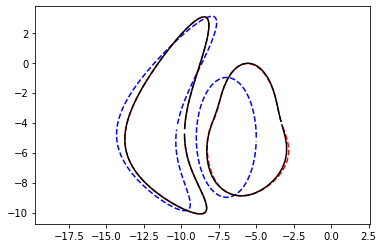

In [9]:
shape0_defo = out[0][0]
shape1_defo = out[1][0]

plt.plot(source[0][:,0].detach(), source[0][:,1].detach(), '--b')
plt.plot(source[1][:,0].detach(), source[1][:,1].detach(), '--b')
plt.plot(target[0][:,0].detach(), target[0][:,1].detach(), '--r')
plt.plot(target[1][:,0].detach(), target[1][:,1].detach(), '--r')
plt.plot(shape0_defo[:,0].detach(), shape0_defo[:,1].detach(), '-k')
plt.plot(shape1_defo[:,0].detach(), shape1_defo[:,1].detach(), '-k')
plt.axis('equal')
plt.show()

In [10]:
fac = 5
grid_resolution = [fac*9, fac*4]
gridmod = dm.DeformationModules.DeformationGrid(dm.Utilities.AABB.build_from_points(torch.cat([source[0], source[1]])).scale([1.5,1.]), grid_resolution)

In [11]:
grid = gridmod.togrid()

In [12]:
max(gridmod.manifold.gd[:,1])

tensor(3.0990)

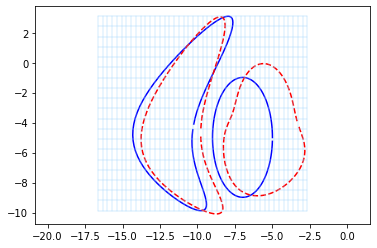

In [13]:

ax = plt.subplot()
plt.plot(source[0][:,0].detach(), source[0][:,1].detach(), '-b')
plt.plot(source[1][:,0].detach(), source[1][:,1].detach(), '-b')
plt.plot(target[0][:,0].detach(), target[0][:,1].detach(), '--r')
plt.plot(target[1][:,0].detach(), target[1][:,1].detach(), '--r')

dm.Utilities.plot_grid(ax, grid[0], grid[1], color='xkcd:light blue', lw=0.4)
plt.axis('equal')
plt.show()

In [14]:

boundary0 = dm.MultiShape.Boundary(copy.copy(source[0][::NN]))
boundary1 = dm.MultiShape.Boundary(copy.copy(source[1][::NN]))


In [15]:
ind_grid_0 = torch.where(boundary0.isin_label(gridmod.manifold.gd)==True)
ind_grid_1 = torch.where(boundary1.isin_label(gridmod.manifold.gd)==True)
ind_grid_bck = torch.where((boundary0.isin_label(gridmod.manifold.gd)==False)*(boundary1.isin_label(gridmod.manifold.gd)==False)==True)

In [16]:
pts_0 = gridmod.manifold.gd[ind_grid_0].clone().contiguous()
pts_1 = gridmod.manifold.gd[ind_grid_1].clone().contiguous()
pts_bck = gridmod.manifold.gd[ind_grid_bck].clone().contiguous()

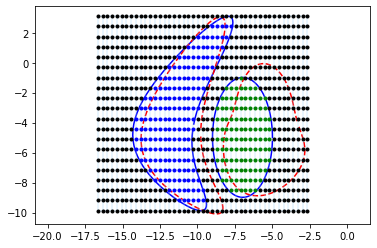

In [17]:

ax = plt.subplot()
plt.plot(source[0][:,0].detach(), source[0][:,1].detach(), '-b')
plt.plot(source[1][:,0].detach(), source[1][:,1].detach(), '-b')
plt.plot(target[0][:,0].detach(), target[0][:,1].detach(), '--r')
plt.plot(target[1][:,0].detach(), target[1][:,1].detach(), '--r')

dm.Utilities.plot_grid(ax, grid[0], grid[1], color='xkcd:light blue', lw=0.4)
plt.plot(pts_0[:,0].detach(), pts_0[:,1].detach(), '.b')
plt.plot(pts_1[:,0].detach(), pts_1[:,1].detach(), '.g')
plt.plot(pts_bck[:,0].detach(), pts_bck[:,1].detach(), '.k')

plt.axis('equal')
plt.show()

In [18]:
module_list = model.modules

In [19]:
for i, mod in enumerate(module_list):
    mod.manifold.fill_gd(model.init_manifold[i].gd)
    mod.manifold.fill_cotan(model.init_manifold[i].cotan)

In [20]:
grid0_deformable = dm.Models.DeformablePoints(pts_0)
grid1_deformable = dm.Models.DeformablePoints(pts_1)
gridbck_deformable = dm.Models.DeformablePoints(pts_bck)
grids_deformable = [grid0_deformable, grid1_deformable, gridbck_deformable]

In [21]:
module_list_grid = []
for mod, defgrid in zip(module_list[:-1], grids_deformable[:-1]):
    module_list_grid.append(dm.DeformationModules.CompoundModule([mod[0], defgrid.silent_module, *mod[1:]]))
module_list_grid.append(dm.DeformationModules.CompoundModule([*module_list[-1], grids_deformable[-1].silent_module]))

In [22]:

compound_man_grid = dm.MultiShape.MultishapeCompoundManifold.MultishapeCompoundManifold([dm.Manifolds.CompoundManifold([source_deformable0.silent_module.manifold.clone(requires_grad=True), grid0_deformable.silent_module.manifold.clone(requires_grad=True), rotation.manifold.clone(requires_grad=True), boundary0.silent_module.manifold.clone(requires_grad=True)]), dm.Manifolds.CompoundManifold([source_deformable1.silent_module.manifold.clone(requires_grad=True), grid1_deformable.silent_module.manifold.clone(requires_grad=True), scaling.manifold.clone(requires_grad=True), translation.manifold.clone(requires_grad=True), boundary1.silent_module.manifold.clone(requires_grad=True)]), dm.Manifolds.CompoundManifold([boundary0.silent_module.manifold.clone(requires_grad=True), boundary1.silent_module.manifold.clone(requires_grad=True), gridbck_deformable.silent_module.manifold.clone(requires_grad=True)])])
sigma_bck = 0.1
#constraints = dm.Constraints.Constraints.ConstraintsPointIdentityBase([0, 0], [1, 0], compound_man)
constraints0_grid = dm.Constraints.Constraints.ConstraintsPointIdentityBackground(0, compound_man_grid)
constraints1_grid = dm.Constraints.Constraints.ConstraintsPointIdentityBackground(1, compound_man_grid)
constraints_grid = dm.Constraints.Constraints.CompoundConstraints([constraints0_grid, constraints1_grid])


In [23]:
multishape_grid = dm.MultiShape.MultiShape.MultiShapeModules(module_list_grid, sigma_bck)
Ham_grid = MultiShapeHamiltonian.Hamiltonian_multishape(multishape_grid, constraints_grid)
shoot(Ham_grid, shoot_solver, shoot_it)
shape0_defo_grid = Ham_grid.module.modules[0][0].manifold.gd
shape1_defo_grid = Ham_grid.module.modules[1][0].manifold.gd

In [24]:
grid0_deformed_pts = Ham_grid.module.modules[0][1].manifold.gd
grid1_deformed_pts = Ham_grid.module.modules[1][1].manifold.gd
gridbck_deformed_pts = Ham_grid.module.modules[2][-1].manifold.gd

In [25]:
gridmod.manifold.gd[ind_grid_0] = grid0_deformed_pts.clone()
gridmod.manifold.gd[ind_grid_1] = grid1_deformed_pts.clone()
gridmod.manifold.gd[ind_grid_bck] = gridbck_deformed_pts.clone()

In [26]:
grid_deformed = gridmod.togrid()

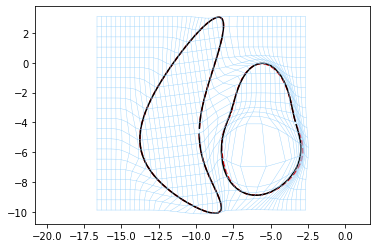

In [27]:

ax = plt.subplot()
#plt.plot(source[0][:,0].detach(), source[0][:,1].detach(), '-b')
#plt.plot(source[1][:,0].detach(), source[1][:,1].detach(), '-b')
plt.plot(target[0][:,0].detach(), target[0][:,1].detach(), '--r')
plt.plot(target[1][:,0].detach(), target[1][:,1].detach(), '--r')
plt.plot(shape0_defo_grid[:,0].detach(), shape0_defo[:,1].detach(), '-k')
plt.plot(shape1_defo_grid[:,0].detach(), shape1_defo[:,1].detach(), '-k')

dm.Utilities.plot_grid(ax, grid_deformed[0], grid_deformed[1], color='xkcd:light blue', lw=0.4)
plt.axis('equal')
plt.show()